# Movie Review ML

## Importações 

### Bibliotecas para cálculos com array 
Pacotes de biblioteca cientificas para calculos com arrays n-dimensionais e outras funções

In [2]:
import os
import pandas
import numpy

### Modelos

Modelos de classificação linear, Naive Bayes e SVN como soluções mais utilizadas nas pesquisas que são simples e que atingem o objetivo de lidar com textos.

In [3]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

### Engenharia de características

Foram utilizadas as bibliotecas TextBlob e Tfidf, sendo essa propria da Scikit learn 

In [4]:
from dense_transform import DenseTransformer, tokenizer, tokenizer_correct
from sklearn.feature_extraction.text import TfidfTransformer,  CountVectorizer, TfidfVectorizer

## Gráficos

Para a geração de gráficos foi utilizado o Matplot lib

In [5]:
from matplotlib import pyplot

### Validação de Modelo

Foi utilizada a biblioteca sklearn

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Pipelines

Processamento dos dados utilizando filtragem pelos metodos: gaussian, bernoulli, multinomial, Linear e SGDClassifier

In [7]:
from sklearn.pipeline import Pipeline

### Time

Biblioteca para acesso ao tempo e conversões

In [8]:
import time

### Obtenção de Data

Método utilizado para a obtenção dos dados que irão ser tratados

In [9]:
def obtain_data():
    t0 = time.time()
    global paths_df
    # Load dirs name
    cur_dir = os.path.realpath('.')
    pos_dir = os.path.join(cur_dir, 'train-pos')
    neg_dir = os.path.join(cur_dir, 'train-neg')


    # Load files names
    list_pos_dir = [ (os.path.join(pos_dir, x), 1) for x in os.listdir(pos_dir)][:11]
    list_neg_dir = [ (os.path.join(neg_dir, x), 0) for x in os.listdir(neg_dir)][:11]
    print("registers: {}".format(len(list_pos_dir+list_neg_dir)))
    print("Attention with 6000 registers it will consume about 5+GB of ram")
    # input("Continue? or press CTRL+C")

    # Mount data with label data frame
    paths_df = pandas.DataFrame(list_pos_dir+list_neg_dir, columns=['path', 'label'])

    print("It took: " + str(time.time() - t0) + " to obtain data")
obtain_data()

registers: 22
Attention with 6000 registers it will consume about 5+GB of ram
It took: 0.2001783847808838 to obtain data


### Mostrar números de tokens

Metodo utilizado para a obtenção do número de tokens da aplicação

In [10]:
def show_number_of_tokens():
    t0 = time.time()
    # Verify difference between size of tokens with tokenizer stem, stopwords
    tfidf_stem = TfidfVectorizer(input='filename', stop_words='english', tokenizer=tokenizer)
    tfidf_tokenizer_correct = TfidfVectorizer(input='filename', stop_words='english', tokenizer=tokenizer_correct)
    tfidf_stem.fit(paths_df.path.values)
    tfidf_stem.get_feature_names()
    tfidf_stop = TfidfVectorizer(input='filename', stop_words='english')
    tfidf_word = TfidfVectorizer(input='filename')


    # Simple benchmark for number of features
    result = []
    for tfidf in [tfidf_stem, tfidf_word, tfidf_stop, tfidf_tokenizer_correct]:
        tfidf.fit(paths_df.path.values)
        result.append(len(tfidf.get_feature_names()))

    result = pandas.DataFrame(result, columns=['len_of_features'], index=['tfidf_stem', 'tfidf_word', 'tfidf_stop', 'tfidf_tokenizer_correct'])
    result = result.assign(difference=lambda x: (x.len_of_features - x.len_of_features.min()))
    print(result)
    pyplot.figure(1)
    pyplot.bar([1,2,3,4], result.difference.values)
    pyplot.xticks([1,2,3], result.index.values)
    pyplot.ylabel('Number of tokens')
    pyplot.xlabel('Method of tf-idf')
    print("It took: " + str(time.time() - t0) + " to show number of tokens")
show_number_of_tokens()    

                         len_of_features  difference
tfidf_stem                          1136           0
tfidf_word                          1424         288
tfidf_stop                          1233          97
tfidf_tokenizer_correct             1199          63
It took: 240.0510654449463 to show number of tokens


### Criação de Pipelines

Método para criação de pipelines para tratamento dos dados em etapas utilizando os metodos de gaussian, bernoulli, multinomial, Linear e SGDClassifier

In [11]:
def create_pipes():
    global pipes
    t0 = time.time()
    # Create pipes
    pipes = {
        'gaussianNB': Pipeline([
          ('vect', TfidfVectorizer(input='filename')),
          ('dense', DenseTransformer()),
          ('gnb', GaussianNB())
        ]),
        'bernoulliNB': Pipeline([
          ('vect', TfidfVectorizer(input='filename', binary=True)),
          ('dense', DenseTransformer()),
          ('gnb', BernoulliNB())
        ]),
        'multinomialNB': Pipeline([
          ('vect', TfidfVectorizer(input='filename')),
          ( 'gnb', MultinomialNB())
        ]),
        'linearSVC': Pipeline([
          ('vect', TfidfVectorizer(input='filename')),
          ( 'gnb', LinearSVC())
        ]),
        'sgdclassifier': Pipeline([
          ('vect', TfidfVectorizer(input='filename')),
          ( 'gnb', SGDClassifier(max_iter=5))
        ]),
    }
    print("It took: " + str(time.time() - t0) + " to create pipes")
# Method to return params from pipe params adjusts
create_pipes()

It took: 0.001070261001586914 to create pipes


### Extração de parâmetros

Criação de um método que retorna parâmetros ajustados dos *pipes* 

In [12]:
def extract_params(best_params_):
    return {'ngram_range': best_params_['vect__ngram_range'],
      'use_idf': best_params_['vect__use_idf'],
      'norm':  best_params_['vect__norm'],
      'sublinear_tf': best_params_['vect__sublinear_tf'],
      'stop_words': best_params_['vect__stop_words'],
      'tokenizer': best_params_['vect__tokenizer']
    }


### Definição de parâmetros

Método para definição de parâmetros para *pipeline* e verificação do tempo de processamento para definição destes parâmetros. 

In [13]:
def define_params():
    # Define params
    t0 = time.time()
    global parameters
    parameters = {
      'vect__ngram_range': [(1,1), (1,2)],
      'vect__use_idf': (True, False),
      'vect__norm':  ('l2', 'l1', None),
      'vect__sublinear_tf': (True, False),
      'vect__stop_words': ('english', None),
      'vect__tokenizer': (None, tokenizer),
    }
    print("It took: " + str(time.time() - t0) + " to define parameters")
define_params()


It took: 3.814697265625e-06 to define parameters


### Processamento de dados no *pipeline*

Métodos de processamento da *pipeline*, onde cada processo de filtragem é feito o treinamento em sequência para tratamento dos melhores valores dentro da cadeia de funções presentes no *pipeline*. Em cada um dos métodos é verificado o tempo de processamento para validação da performance.

In [14]:
def run_gaussian_NB_pipeline():
    t0 = time.time()
    # Initialize best parameters search
    parametrized = GridSearchCV(pipes['gaussianNB'], parameters, n_jobs=3)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedgaussianNB'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', **extract_params(parametrized.best_params_))),
          ('dense', DenseTransformer()),
          ('gnb', GaussianNB())
        ])
    print("It took: " + str(time.time() - t0) + " to run gaussian NB pipeline")
run_gaussian_NB_pipeline()


0.727272727273 {'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__sublinear_tf': True, 'vect__tokenizer': None, 'vect__use_idf': True}
It took: 62.35296416282654 to run gaussian NB pipeline


In [15]:

def run_bernoulli_NB_pipeline():
    t0 = time.time()
    parametrized = GridSearchCV(pipes['bernoulliNB'], parameters, n_jobs=3)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedbernoulliNB'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', binary=True, **extract_params(parametrized.best_params_))),
          ('dense', DenseTransformer()),
          ('gnb', BernoulliNB())
        ])
    print("It took: " + str(time.time() - t0) + " to run bernoulli NB pipeline")
run_bernoulli_NB_pipeline()

0.545454545455 {'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__sublinear_tf': True, 'vect__tokenizer': <function tokenizer at 0x7f90a4175bf8>, 'vect__use_idf': True}
It took: 72.87842845916748 to run bernoulli NB pipeline


In [16]:

def run_multinomial_NB_pipeline():
    t0 = time.time()

    parametrized = GridSearchCV(pipes['multinomialNB'], parameters, n_jobs=3)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedmultinomialNB'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', **extract_params(parametrized.best_params_))),
          ( 'gnb', MultinomialNB())
        ])
    print("It took: " + str(time.time() - t0) + " to run multinomial NB pipeline")
run_multinomial_NB_pipeline()

0.772727272727 {'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__sublinear_tf': False, 'vect__tokenizer': <function tokenizer at 0x7f90a4175bf8>, 'vect__use_idf': True}
It took: 54.66628837585449 to run multinomial NB pipeline


In [17]:

def run_linearSVC_pipeline():
    t0 = time.time()
    parametrized = GridSearchCV(pipes['linearSVC'], parameters, n_jobs=1)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedlinearSVC'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', **extract_params(parametrized.best_params_))),
          ('gnb', LinearSVC())
        ])
    print("It took: " + str(time.time() - t0) + " to run linear SVC pipeline")
run_linearSVC_pipeline()

0.818181818182 {'vect__norm': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english', 'vect__sublinear_tf': True, 'vect__tokenizer': None, 'vect__use_idf': True}
It took: 170.41673851013184 to run linear SVC pipeline


In [18]:

def run_sgdclassifier_pipeline():
    t0 = time.time()

    parametrized = GridSearchCV(pipes['linearSVC'], parameters, n_jobs=3)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedlinearSVC'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', **extract_params(parametrized.best_params_))),
          ('gnb', LinearSVC())
        ])
    parametrized = GridSearchCV(pipes['sgdclassifier'], parameters, n_jobs=3)
    parametrized.fit(paths_df.path,paths_df.label)
    print(parametrized.best_score_, parametrized.best_params_)

    pipes['optimizedsgdclassifier'] = Pipeline([
          ('vect', TfidfVectorizer(input='filename', **extract_params(parametrized.best_params_))),
          ('gnb', SGDClassifier())
        ])

    print("It took: " + str(time.time() - t0) + " to run SGD classifier pipeline")
run_sgdclassifier_pipeline()

0.818181818182 {'vect__norm': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english', 'vect__sublinear_tf': True, 'vect__tokenizer': None, 'vect__use_idf': True}
0.863636363636 {'vect__norm': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__sublinear_tf': True, 'vect__tokenizer': None, 'vect__use_idf': True}
It took: 149.66648292541504 to run SGD classifier pipeline


/home/joao4018/machine/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Treinamento dos dados do *pipeline*

Método para o treinamento dos dados tratados da *pipeline* utilizando a biblioteca pandas para as operações com *arrays* 

In [25]:
def mount_and_train():
    t0 = time.time()
    # Execute each pipe in dictionary pipes doing    # a score with test and train bases
    # Variate the size of test and train bases
    index = [x/10.0 for x in range(1,8)]
    global df
    df = pandas.DataFrame(index=index)
    for pipe_name, pipe in pipes.items():
        temp = []
        for l in range(1,8):
            # Split into train and test
            # X - Train, Y - Train
            # x - test, y - test
            X, x, Y, y = train_test_split(
                paths_df.path, paths_df.label, test_size=l/10.0, random_state=0
            )
            pipe.fit(X,Y)
            temp.append([pipe.score(X,Y), pipe.score(x,y)])
        columns = ["train_{}".format(pipe_name), "test_{}".format(pipe_name)]
        new_df = pandas.DataFrame(temp, columns=columns, index=index)
        df = df.join(new_df)
    print("It took: " + str(time.time() - t0) + " to mount and train")
mount_and_train()

It took: 18.724443197250366 to mount and train


### Gráficos

Demonstração de gráficos utilizando a biblioteca pyplot. Foi feita a geração dos dados obtidos em todas as etapas da *pipeline* junto com suas pontuações.

     train_optimizedbernoulliNB  test_optimizedbernoulliNB  \
0.4                    1.000000                   0.333333   
0.6                    1.000000                   0.500000   
0.1                    0.894737                   0.333333   
0.5                    1.000000                   0.363636   
0.2                    0.941176                   0.400000   
0.7                    1.000000                   0.500000   
0.4                    1.000000                   0.333333   
0.6                    1.000000                   0.500000   
0.1                    0.894737                   0.333333   
0.1                    0.894737                   0.333333   
0.1                    0.894737                   0.333333   
0.6                    1.000000                   0.500000   
0.1                    0.894737                   0.333333   
0.1                    0.894737                   0.333333   
0.1                    0.894737                   0.333333   
0.3     

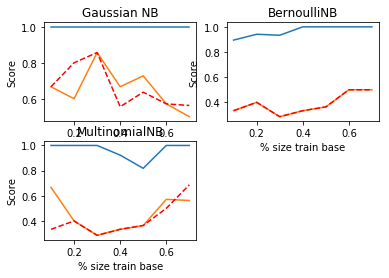

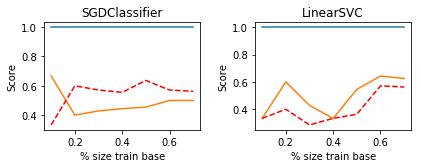

It took: 3.8267462253570557 to plot graphs


In [23]:
def plot_all():
    t0 = time.time()
    # Plot all
    pyplot.figure(2)

    pyplot.subplot(221)
    pyplot.title('Gaussian NB')
    pyplot.plot(df.train_gaussianNB)
    pyplot.plot(df.test_gaussianNB)
    pyplot.plot(df.test_optimizedgaussianNB, 'r--')
    pyplot.ylabel("Score")
    pyplot.xlabel("% size train base")

    pyplot.subplot(222)
    pyplot.title('BernoulliNB')
    pyplot.plot(df.train_bernoulliNB)
    pyplot.plot(df.test_bernoulliNB)
    pyplot.plot(df.test_optimizedbernoulliNB, 'r--')
    pyplot.ylabel("Score")
    pyplot.xlabel("% size train base")


    pyplot.subplot(223)
    pyplot.title('MultinomialNB')
    pyplot.plot(df.train_multinomialNB)
    pyplot.plot(df.test_multinomialNB)
    pyplot.plot(df.test_optimizedmultinomialNB, 'r--')
    pyplot.ylabel("Score")
    pyplot.xlabel("% size train base")

    pyplot.figure(3)
    pyplot.subplot(222)
    pyplot.title('LinearSVC')
    pyplot.plot(df.train_linearSVC)
    pyplot.plot(df.test_linearSVC)
    pyplot.plot(df.test_optimizedlinearSVC, 'r--')
    pyplot.ylabel("Score")
    pyplot.xlabel("% size train base")


    pyplot.subplot(221)
    pyplot.title('SGDClassifier')
    pyplot.plot(df.train_sgdclassifier)
    pyplot.plot(df.test_sgdclassifier)
    pyplot.plot(df.test_optimizedsgdclassifier, 'r--')
    pyplot.ylabel("Score")
    pyplot.xlabel("% size train base")
    pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    print(df.ix[df.idxmax()])

    pyplot.show()
    print("It took: " + str(time.time() - t0) + " to plot graphs")
plot_all()